# Preparation

In [ ]:
# Use cd commond to change directory to working folder
# cd

In [3]:
import os
import random
import numpy as np
import pandas as pd
import sys
import sklearn
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from summa import keywords
from nltk.tokenize import sent_tokenize , word_tokenize
import wikipedia
import spacy
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from nltk.stem import *
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer 
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk import word_tokenize

d:\anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
text_data=pd.read_csv('speech100.csv',index_col= 0)
text_data[:10]

,Title,Lecturer,Year,Doc,clean,profession,gender,party,age_then
0,I Have A Dream,"Martin Luther King, Jr.",1963,I am happy to join with you today in what will...,happy history great demonstration freedom hist...,American minister,male,Null,34
1,Inaugural Address,John Fitzgerald Kennedy,1961,"Vice President Johnson, Mr. Speaker, Mr. Chief...",johnson speaker chief justice eisenhower nixon...,35th U.S. President,male,Null,44
2,First Inaugural Address-Franklin Delano Roosevelt,Franklin Delano Roosevelt,1933,"President Hoover, Mr. Chief Justice, my friend...",hoover chief justice friend national consecrat...,32nd U.S. President,male,Democratic,51
3,Pearl Harbor Address to the Nation,Franklin Delano Roosevelt,1941,"Mr. Vice President, Mr. Speaker, Members of th...",speaker members senate house representatives y...,32nd U.S. President,male,Democratic,59
4,1976 DNC Keynote Address,Barbara Charline Jordan,1976,Thank you ladies and gentlemen for a very warm...,gentleman reception member democratic party co...,Former United States Representative,female,Null,40
5,"""My Side of the Story"" (""Checkers"")",Richard Milhous Nixon,1952,"My Fellow Americans, I come before you tonight...",fellow candidate presidency honesty integrity ...,37th U.S. President,male,Republican,39
6,The Ballot or the Bullet,Malcolm X,1964,"Mr. Moderator, Rev. Cleage, brothers and siste...",moderator cleage brother sister friend enemy a...,American minister,male,Republican,39
7,Shuttle 'Challenger' Disaster Address,Ronald Wilson Reagan,1986,"Ladies and Gentlemen, I'd planned to speak to ...",ladies gentlemen speak report state union even...,40th U.S. President,male,Republican,75
8,Houston Ministerial Association,John Fitzgerald Kennedy,1960,"Reverend Meza, Reverend Reck, I'm grateful for...",reverend reverend grateful generous invitation...,35th U.S. President,male,Null,43
9,We Shall Overcome,Lyndon Baines Johnson,1965,"Mr. Speaker, Mr. President, Members of the Con...",speaker members congress speak dignity destiny...,36th U.S. President,male,Democratic,57


# LDA

In [17]:
processed_docs=[]
for i in range(0,100):
    processed_docs.append(word_tokenize(text_data["clean"][i]))

dictionary = gensim.corpora.Dictionary(processed_docs)  # Bag of words
dictionary.filter_extremes(no_below=2, no_above=0.8)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# iteration  - get the best parameters
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, start=3, limit=8, step=1)


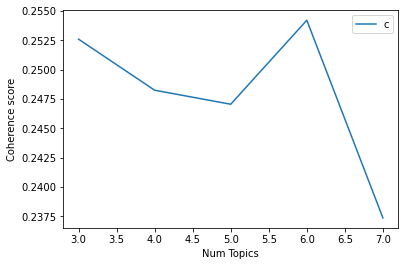

In [18]:
# Show graph
limit=8; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**num_topics=6  Best is the 6 topics**

In [12]:
num_topics=6  #best is the 6 topics
# running LDA
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics =6, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2,random_state=123)

# The output from the model is  9  topics each categorized by a series of words
print(lda_model.print_topics())

# Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0, '0.010*"congress" + 0.008*"power" + 0.008*"public" + 0.007*"government" + 0.006*"church" + 0.006*"religious" + 0.005*"state" + 0.005*"abortion" + 0.005*"child" + 0.005*"question"'), (1, '0.029*"woman" + 0.016*"government" + 0.009*"human" + 0.009*"party" + 0.007*"freedom" + 0.005*"state" + 0.005*"child" + 0.005*"political" + 0.005*"force" + 0.004*"economic"'), (2, '0.016*"white" + 0.014*"black" + 0.010*"question" + 0.010*"public" + 0.007*"party" + 0.007*"network" + 0.007*"television" + 0.006*"power" + 0.006*"problem" + 0.005*"freedom"'), (3, '0.011*"peace" + 0.010*"government" + 0.008*"vietnam" + 0.006*"freedom" + 0.006*"south" + 0.005*"child" + 0.004*"force" + 0.004*"human" + 0.004*"young" + 0.004*"action"'), (4, '0.008*"government" + 0.007*"money" + 0.005*"labor" + 0.005*"dollar" + 0.004*"human" + 0.004*"young" + 0.004*"friend" + 0.004*"state" + 0.004*"office" + 0.004*"question"'), (5, '0.015*"white" + 0.013*"revolution" + 0.012*"black" + 0.010*"senator" + 0.009*"government" + 0.

In [15]:
## Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models  as gensim_models
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, bow_corpus, dictionary)
vis

d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.010544  0.031177       1        1  32.155395
0      0.057360  0.000520       2        1  17.892052
1      0.062348 -0.018967       3        1  17.882323
4      0.071373 -0.039699       4        1  15.712885
2     -0.053479  0.105214       5        1   9.423425
5     -0.127058 -0.078245       6        1   6.933919, topic_info=            Term        Freq       Total Category  logprob  loglift
1430       woman  539.000000  539.000000  Default  30.0000  30.0000
248        white  250.000000  250.000000  Default  29.0000  29.0000
11         black  210.000000  210.000000  Default  28.0000  28.0000
409   revolution  115.000000  115.000000  Default  27.0000  27.0000
1423     vietnam  214.000000  214.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
382        party   24.232058  326.222769   Topic6  -5.3814   0.0688
82       freedom   24.490720  355.515337   Topic6  -5.3708  -0.0065
328        fight   21.041685  211.215371   Topic6  -5.5226   0.3624
1228      church   19.073270  161.423929   Topic6  -5.6208   0.5330
205        south   19.274743  199.896086   Topic6  -5.6103   0.3297

[470 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
4597      2  0.860865  abolitionist
3778      1  0.013553      abortion
3778      2  0.962230      abortion
3778      3  0.013553      abortion
4460      5  0.753146    accounting
...     ...       ...           ...
465       2  0.037494         young
465       3  0.053563         young
465       4  0.283882         young
465       5  0.042850         young
465       6  0.064275         young

[1253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 3, 6])

In [16]:
# Topic assigned to each topic
def get_lda_topics(model, num_topics):
    """Print lda topics with pd.DataFrame"""
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 16)
        word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
        
    return pd.DataFrame(word_dict).transpose()

get_lda_topics(lda_model, num_topics)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Topic #01,congress,power,public,government,church,religious,state,abortion,child,question,force,catholic,constitution,peace,issue,purpose
Topic #02,woman,government,human,party,freedom,state,child,political,force,economic,family,communist,society,prove,individual,problem
Topic #03,white,black,question,public,party,network,television,power,problem,freedom,community,start,child,atomic,national,government
Topic #04,peace,government,vietnam,freedom,south,child,force,human,young,action,history,place,party,speak,family,fight
Topic #05,government,money,labor,dollar,human,young,friend,state,office,question,power,woman,political,league,matter,principle
Topic #06,white,revolution,black,senator,government,negro,nationalism,community,house,energy,power,political,negroes,philosophy,mccarthy,control


In [17]:
# Get topis for the all speech
# Probability distribution attributable to each item
all_topics = lda_model.get_document_topics(bow_corpus, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
all_topics_df.rename(columns=lambda x:x+1, inplace=True)
all_topics_df

,1,2,3,4,5,6
0,0.000434,0.000434,0.997832,0.000434,0.000433,0.000433
1,0.000504,0.000504,0.000504,0.997481,0.000504,0.000504
2,0.119834,0.000308,0.000308,0.878935,0.000308,0.000307
3,0.994500,0.001097,0.001097,0.001102,0.001106,0.001098
4,0.000349,0.000349,0.998254,0.000350,0.000349,0.000349
...,...,...,...,...,...,...
95,0.000420,0.000419,0.000419,0.997903,0.000419,0.000419
96,0.000468,0.000469,0.000469,0.000468,0.000470,0.997655
97,0.040749,0.257335,0.000343,0.000344,0.700887,0.000342
98,0.000161,0.018715,0.000161,0.980642,0.000161,0.000161


In [18]:
# Get the maximum probability in each row
lda_topic=all_topics_df.idxmax(1).to_list()
text_data["LDA_topic"]=lda_topic
sub_df=text_data.loc[text_data["LDA_topic"]==1]

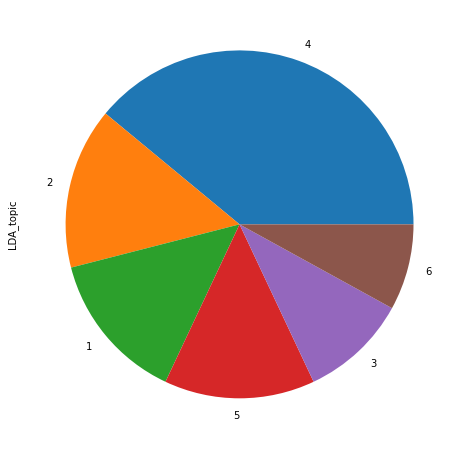

In [19]:
plt.rcParams['figure.figsize'] = [20, 8]
text_data.LDA_topic.value_counts().plot(kind='pie')
plt.show()

# Preparation for NMF

In [20]:
n_features = 1000 
#If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
n_components = 6
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, n_components, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.



In [21]:
# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_features=n_features)
tfidf = tfidf_vectorizer.fit_transform(text_data['clean'])

# NMF with Kullback-leibler

d:\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


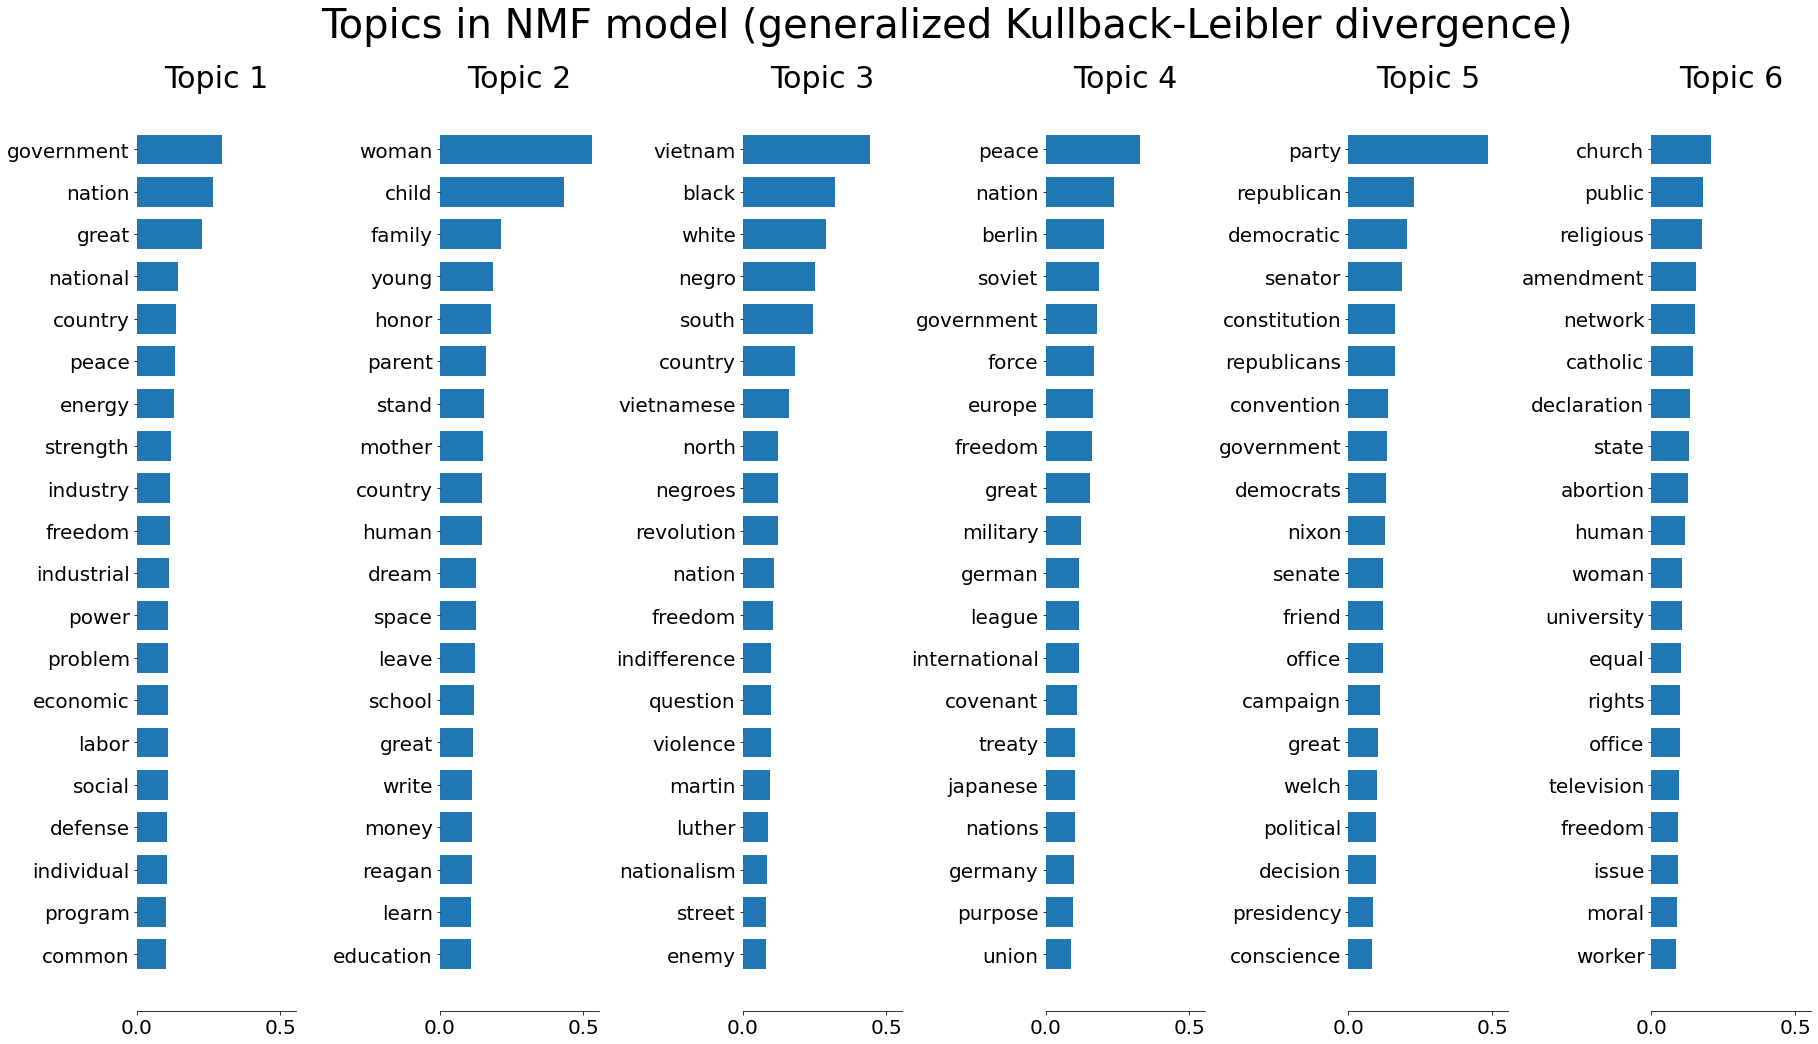

In [22]:
nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5).fit(tfidf)


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

## Topic distribution
According to the representative words, we can summarise the topic as follow:

<span class="mark">1. American value/ Universal Value/ American Government\
2. Family/ Education/ Love/ Women\
3. Race\
4. War/ diplomatic\
5. Party/ constitution\
6. Religion</span>

## Frequency table

NMF using Kullback-leibler

The number of articles belonging to each topic is well balanced

In [23]:
w=nmf.fit_transform(tfidf)
topic_doc=np.argmax(w, axis=1)
topic_doc
unique, counts = np.unique(topic_doc, return_counts=True)
print(np.asarray((unique, counts)).T)

d:\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


[[ 0 22]
 [ 1 20]
 [ 2 15]
 [ 3 18]
 [ 4 11]
 [ 5 14]]


### Topic label 
Add a column, to represent the topic of the document

In [24]:
# Add a column model label
text_data['NMF_topic'] = [(w+1) for w in topic_doc]
text_data[:10]

,Title,Lecturer,Year,Doc,clean,profession,gender,party,age_then,LDA_topic,NMF_topic
0,I Have A Dream,"Martin Luther King, Jr.",1963,I am happy to join with you today in what will...,happy history great demonstration freedom hist...,American minister,male,Null,34,3,3
1,Inaugural Address,John Fitzgerald Kennedy,1961,"Vice President Johnson, Mr. Speaker, Mr. Chief...",johnson speaker chief justice eisenhower nixon...,35th U.S. President,male,Null,44,4,1
2,First Inaugural Address-Franklin Delano Roosevelt,Franklin Delano Roosevelt,1933,"President Hoover, Mr. Chief Justice, my friend...",hoover chief justice friend national consecrat...,32nd U.S. President,male,Democratic,51,4,1
3,Pearl Harbor Address to the Nation,Franklin Delano Roosevelt,1941,"Mr. Vice President, Mr. Speaker, Members of th...",speaker members senate house representatives y...,32nd U.S. President,male,Democratic,59,1,4
4,1976 DNC Keynote Address,Barbara Charline Jordan,1976,Thank you ladies and gentlemen for a very warm...,gentleman reception member democratic party co...,Former United States Representative,female,Null,40,3,5
5,"""My Side of the Story"" (""Checkers"")",Richard Milhous Nixon,1952,"My Fellow Americans, I come before you tonight...",fellow candidate presidency honesty integrity ...,37th U.S. President,male,Republican,39,5,5
6,The Ballot or the Bullet,Malcolm X,1964,"Mr. Moderator, Rev. Cleage, brothers and siste...",moderator cleage brother sister friend enemy a...,American minister,male,Republican,39,6,3
7,Shuttle 'Challenger' Disaster Address,Ronald Wilson Reagan,1986,"Ladies and Gentlemen, I'd planned to speak to ...",ladies gentlemen speak report state union even...,40th U.S. President,male,Republican,75,4,2
8,Houston Ministerial Association,John Fitzgerald Kennedy,1960,"Reverend Meza, Reverend Reck, I'm grateful for...",reverend reverend grateful generous invitation...,35th U.S. President,male,Null,43,1,6
9,We Shall Overcome,Lyndon Baines Johnson,1965,"Mr. Speaker, Mr. President, Members of the Con...",speaker members congress speak dignity destiny...,36th U.S. President,male,Democratic,57,3,3


In [25]:
text_data[text_data["NMF_topic"]==3][:10]

,Title,Lecturer,Year,Doc,clean,profession,gender,party,age_then,LDA_topic,NMF_topic
0,I Have A Dream,"Martin Luther King, Jr.",1963,I am happy to join with you today in what will...,happy history great demonstration freedom hist...,American minister,male,Null,34,3,3
6,The Ballot or the Bullet,Malcolm X,1964,"Mr. Moderator, Rev. Cleage, brothers and siste...",moderator cleage brother sister friend enemy a...,American minister,male,Republican,39,6,3
9,We Shall Overcome,Lyndon Baines Johnson,1965,"Mr. Speaker, Mr. President, Members of the Con...",speaker members congress speak dignity destiny...,36th U.S. President,male,Democratic,57,3,3
14,I've Been to the Mountaintop,"Martin Luther King, Jr.",1968,"Thank you very kindly, my friends. As I listen...",kindly friend listen ralph abernathy eloquent ...,American minister,male,Null,39,1,3
16,Remarks on the Assassination of MLK,Robert Francis Kennedy,1968,"Ladies and Gentlemen, I'm only going to talk t...",ladies gentlemen minute evening fellow citizen...,Former United States Attorney General,male,Democratic,43,3,3
20,The Great Silent Majority,Richard Milhous Nixon,1969,"Good evening, my fellow Americans. Tonight I w...",evening fellow subject concern vietnam reason ...,37th U.S. President,male,Republican,56,4,3
42,A Time to Break Silence,"Martin Luther King, Jr.",1967,"Mr. Chairman, ladies and gentlemen: I need not...",chairman gentleman pause delighted delighted e...,American minister,male,Null,38,4,3
45,Civil Rights Address,John Fitzgerald Kennedy,1963,"Good evening, my fellow citizens: This afterno...",evening fellow citizen afternoon follow series...,35th U.S. President,male,Null,46,1,3
48,1988 DNC Address,Jesse Louis Jackson,1988,"Tonight, we pause and give praise and honor to...",pause praise honor place convention yellow bro...,"Former Shadow US Senator, DC",male,Null,47,4,3
62,Black Power,Stokely Carmichael,1966,Thank you very much. Its a privilege and an h...,privilege honor white intellectual ghetto coup...,Political activist,male,Democratic,25,3,3


## Test

### Draw keywords from each topic

In [26]:
keywords_topic = []
for j in range(n_components):
    keywords_topic.append(keywords.keywords(" ".join([i for i in text_data['clean'][(topic_doc==j).tolist()]]),words=50).split('\n'))

In [27]:
for j in range(n_components):
    print("topic",j+1,":",keywords_topic[j],"\n")

topic 1 : ['nation', 'nations', 'national', 'nationally', 'nationality', 'nationalization', 'government', 'govern', 'governments', 'governed', 'great', 'greatly', 'greatness', 'power', 'powerful', 'powerfully', 'peace', 'peaceful', 'peacefully', 'country', 'freedom', 'labor', 'laborer', 'human', 'humanity', 'humane', 'humanize', 'economic', 'economics', 'economically', 'public', 'publicly', 'political', 'politically', 'politic', 'industrial', 'industry', 'progressive politics', 'program', 'force', 'child', 'problem', 'social', 'socialism', 'socially', 'individual', 'individualism', 'individually', 'progress', 'energy', 'place friend', 'history', 'society', 'effort', 'friendly', 'business', 'product', 'productive', 'productivity', 'production', 'secure', 'security', 'securely', 'stand', 'standing', 'build', 'building', 'state', 'stately', 'party', 'congress', 'change', 'order', 'orderly', 'nature', 'natural', 'strength', 'fight', 'continue', 'continuous', 'continuity', 'continued', 'com

### Word cloud per topic

In [28]:
add_stop_words = ['like','youre','ive','im','really','id','ve','just','dont','didnt','thi','wa',
                  'say','know','make','people',"today","way","day","time","year",'tonight']

boring_words = ['say','like','just','dont','don','im',
                'live','youll','youve','things','thing','youre','right','really','lot',
                'make','know','people','way','day',
                'little', 'maybe','men',"americans","america"
                'kind','heart', "american","president","united","states"         
                ]

gist_file = open("gist_stopwords.txt", "r")
content = gist_file.read()
stop_words = content.split(",")+boring_words+add_stop_words

In [29]:
topic=["Topic "+str(i+1) for i in range(6)]
topic

['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6']

In [30]:
wordlist_topic=[]
for i in range(6):
    df=text_data.loc[text_data["NMF_topic"]==i+1]
    df_topic=df["clean"].tolist()
    wordlist_topic.append(" ".join(df_topic))

data={"Topic":topic,"Wordcloud":wordlist_topic}
df_wordcloud=pd.DataFrame(data)
df_wordcloud

,Topic,Wordcloud
0,Topic 1,johnson speaker chief justice eisenhower nixon...
1,Topic 2,ladies gentlemen speak report state union even...
2,Topic 3,happy history great demonstration freedom hist...
3,Topic 4,speaker members senate house representatives y...
4,Topic 5,gentleman reception member democratic party co...
5,Topic 6,reverend reverend grateful generous invitation...


In [31]:
%run word_cloud.py

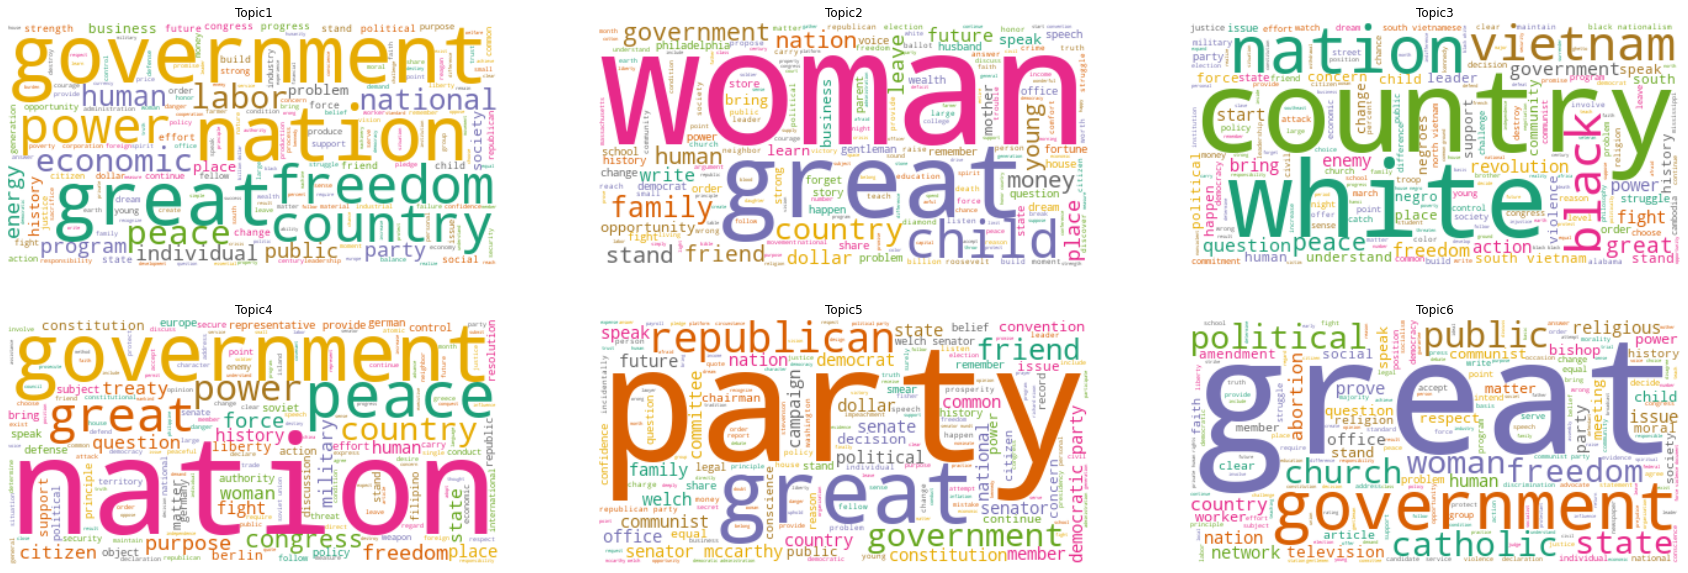

In [32]:
show_word_cloud(df_wordcloud,"Wordcloud",stop_words,collocation_threshold = 30)

### The distribution of time in each topic

In [33]:
for j in range(n_components):
    print("Topic",j+1,":",text_data['Year'][np.where(topic_doc==j)[0]].tolist(),"\n")

Topic 1 : [1961, 1933, 1984, 1906, 1961, 1964, 1981, 1933, 1918, 1974, 1941, 1964, 1947, 1937, 1964, 1968, 1932, 1913, 1920, 1979, 1963, 1966] 

Topic 2 : [1986, 1984, 1962, 1924, 1900, 1934, 1915, 1950, 1995, 1988, 1990, 1992, 1984, 1916, 1939, 1992, 1925, 1983, 1935, 1995] 

Topic 3 : [1963, 1964, 1965, 1968, 1968, 1969, 1967, 1963, 1988, 1966, 1970, 1968, 1963, 1999, 1971] 

Topic 4 : [1941, 1951, 1917, 1963, 1940, 1947, 1953, 1963, 1918, 1900, 1962, 1917, 1984, 1919, 1917, 1920, 1987, 1919] 

Topic 5 : [1976, 1952, 1974, 1950, 1952, 1969, 1948, 1980, 1974, 1974, 1954] 

Topic 6 : [1960, 1983, 1969, 1983, 1948, 1984, 1917, 1961, 1991, 1964, 1968, 1952, 1970, 1948] 



In [34]:
text_data['Topic']=[int(i)+1 for i in topic_doc.tolist()] # add a new column

In [35]:
text_data.to_csv("speech_100_topic.csv",index=False) # save the table

### Topic Analysis

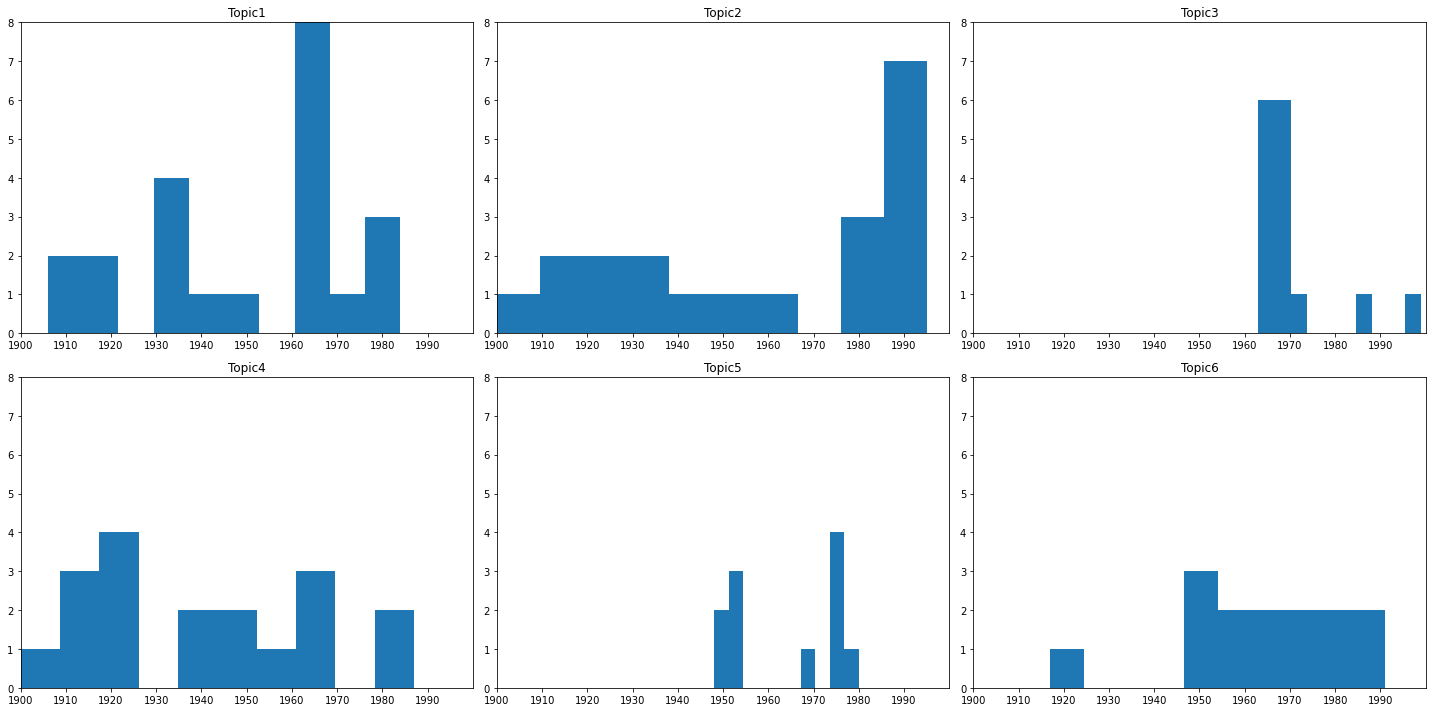

In [36]:
plt.rcParams['figure.figsize'] = [20, 10]

for j in range(n_components):
    ax=plt.subplot(2,3,j+1)
    ax.hist(text_data['Year'][np.where(topic_doc==j)[0]].tolist(),bins=10)
    ax.set_xticks(np.arange(1900,2000,10))
    ax.set_xlim(1900,2000)
    ax.set_ylim(0,8)
    plt.title("Topic"+str(j+1))
    
plt.tight_layout()
plt.show()

## 1. model selection

### LDA topic model
The meaning of the words is not representative. The topics share the same set of high-frequency words, and the words of topics overlap a lot. This is because most of the speeches are made by American politicians, and the topics are very similar. NMF is capable of identifying subtle topics that tend to be under-reported in traditional LDA approaches. When the corpus is small, the NMF performs much better than LDA. 

The figure generated by the NMP shows that the overlapping of words on different topics is reduced. The topics have specific meanings. However, the numbers of documents assigned to each topic differ significantly. Topic 1 includes most of the documents. The other topics share a small part of the speeches, making further analysis much harder. 

The words from each topic are representative and interpretable. The numbers of documents assigned to topics are pretty similar. So we adopt this method to allocate topics to each document. We calculate the probability distribution of topics for each document and then assign the topic with the highest probability to the document. As seen from the table, we can interpret the topics as follows: 

<span class="mark">1. American value/ Universal Value/ American Government\
2. Family/ Education/ Love/ Women\
3. Race\
4. War/ diplomatic\
5. Party/ constitution\
6. Religion</span>

## 2. Topic Year
We find the time of the speeches on each topic. The time distribution of topics is presented in the barplot. We also calculate the mean topic probability distribution of documents every decade. How the topic distribution changes over time is shown in the pictures.

The documents belonging to the topic1 were published throughout the 20th century. As shown from the table, topic 1 is about the American value, Universal values, and American Government, these topics are the basis of American politics so they are focused all the time.

For topic 2, which is related to family, education, love, and women, the documents were most published throughout the century, especially in the late century. In the 1990s, after the cold war, the economy of America flourished so that the politicians and American people cared more about these topics.

The documents on topic 3 are mainly about equal rights, race, and Vietnam War. Most of the speeches on this topic were delivered in the 1960s and 1970s when the Vietnam War began and the Civil Rights Movement was growing.

The speeches of topic 4, which represent war, diplomacy, and Europe, were mainly made in the middle of the 20th century. We can find that the cold war, World War II, and the Cold War happened at that time, which drew the politicians' and the public's attention. 

Topic 5 is related to the party and constitution, which were published throughout the 20th century. Since this topic is always focused on by all politicians no matter when they are in power.

The speeches from topic 6 focused on religion and economy and were mainly delivered in the late 20th century when America had revived from Great Depression and the economy was stimulated. In the 1980s, President Ronald Reagan rejuvenated the conservative Republican ideology, which is the Rise of Conservatism.



In [77]:
year_10 = list(range(1900,2000,10))
year_topic=[]
for i in year_10:
    year_topic.append(w[(text_data['Year']<i+10) & (text_data['Year']>=i).tolist()].mean(axis=0).tolist())

In [81]:
year_topic = pd.DataFrame(year_topic).T

In [82]:
year_topic

,0,1,2,3,4,5
0,0.159367,1.592872e-01,1.305312e-02,0.123806,0.084669,0.083915
1,0.094471,7.842128e-02,6.042566e-04,0.239085,0.049835,0.105970
2,0.098104,2.941815e-01,2.263443e-02,0.046957,0.023294,0.007824
3,0.272997,1.220621e-01,5.582748e-07,0.002389,0.020158,0.043806
4,0.146105,3.010061e-15,3.944082e-03,0.187531,0.057648,0.095614
5,0.043537,5.220719e-02,3.874860e-03,0.129322,0.253407,0.035079
6,0.135796,3.542964e-02,1.781233e-01,0.063639,0.051017,0.091195
7,0.091356,1.092821e-02,1.057170e-01,0.025325,0.253292,0.053389
8,0.107238,1.877575e-01,4.855428e-02,0.063546,0.061316,0.125224
9,0.004995,2.840445e-01,6.625301e-02,0.002382,0.014530,0.086289


0
1
2
3
4
5


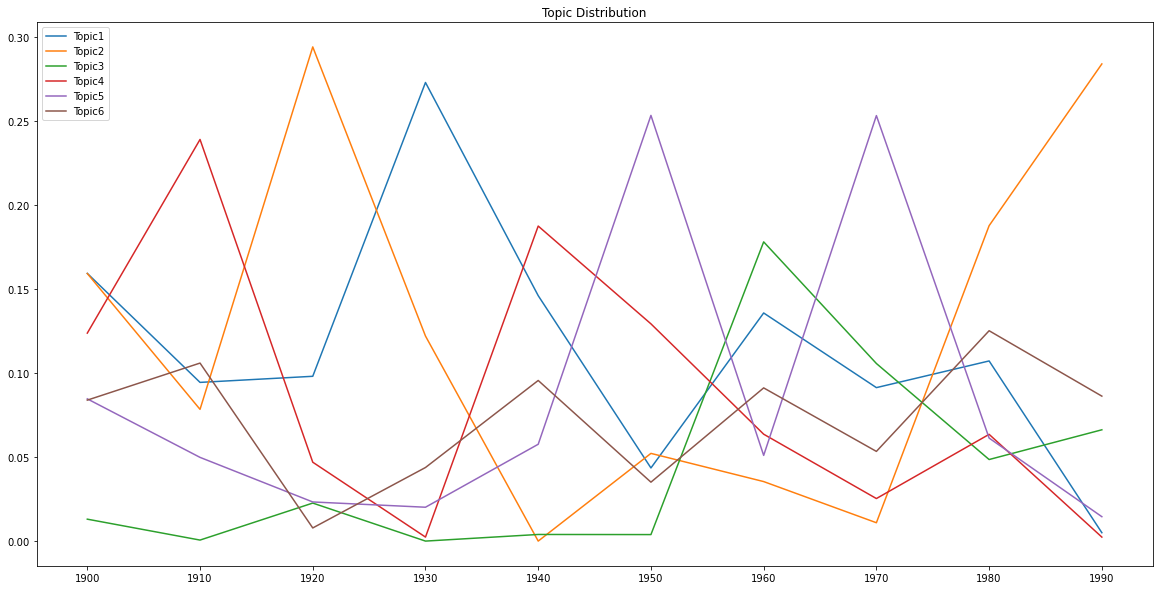

In [84]:
for i in range(6):
    print(i)
    plt.plot(year_10,year_topic[i],label="Topic"+str(i+1))
plt.xticks(np.arange(1900,2000,10))
plt.title("Topic Distribution")
plt.legend()

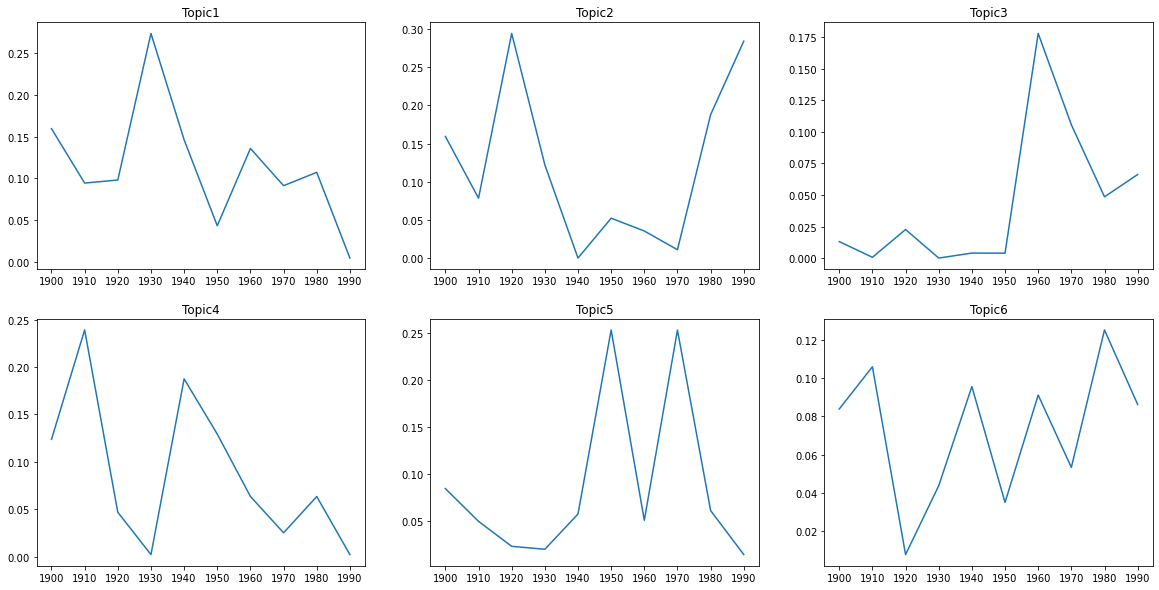

In [85]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(year_10,year_topic[i],label="Topic"+str(i+1))
    plt.xticks(np.arange(1900,2000,10))
    plt.title("Topic"+str(i+1))
    #plt.legend()
#plt.title("Topic Distribution")

## Topic Gender 
The gender and party distribution of each topic is shown separately. 

In general, most of the speeches are given by politicians and there’s 81 out of the 100 speeches are delivered by male speakers, which reflects the unequal participation and leadership in political and public life.

All the speeches on topic 1 (American government) are held by males which again demonstrates the under-representation of women in government positions. Also, there’s a relatively high percentage (approximately 85%) of speeches delivered by male speaker on topic 3, 4 and 6 as well, which are equal rights & race, war & diplomacy respectively and religions respectively. 

On the other hand, around 32% of the speeches on topic 2 (family, education, love and women) and 35% on topic 5 (party and constitution) are given by females. This result is consistent with the fact that family & children care, women affairs & gender equality are the most commonly held portfolios by women ministers and politicians and shows that women have higher interest in the topics relating to constitution and political parties.

## Topic Party

We focus only on the comparison between the two major contemporary political parties in the United States. there are in total 39 speeches delivered by the Democrats and 16 by the Republicans.  

Both of the two parties show great concern in the topic 1 which is associated with American value, Universal values, and American Government, and they show equal interests in topic 5 (party and constitution) as well. This makes sense as topic 1 and 5 should be of main interest of politicians and presidents from either political party.

The Democrats dominate on the topic 2 relating to family, education, love and women and they have a relatively higher number of speeches on the religions and human rights (topic 6).

Most of the speeches on topics 3 and 4 are delivered by speakers with no specific political position, especially on topic 3 which is mainly related to racial equality. This could partly due to the fact that the majority of the US politicians have been white for centuries and black people have been in a relatively inferior position until very recent years.

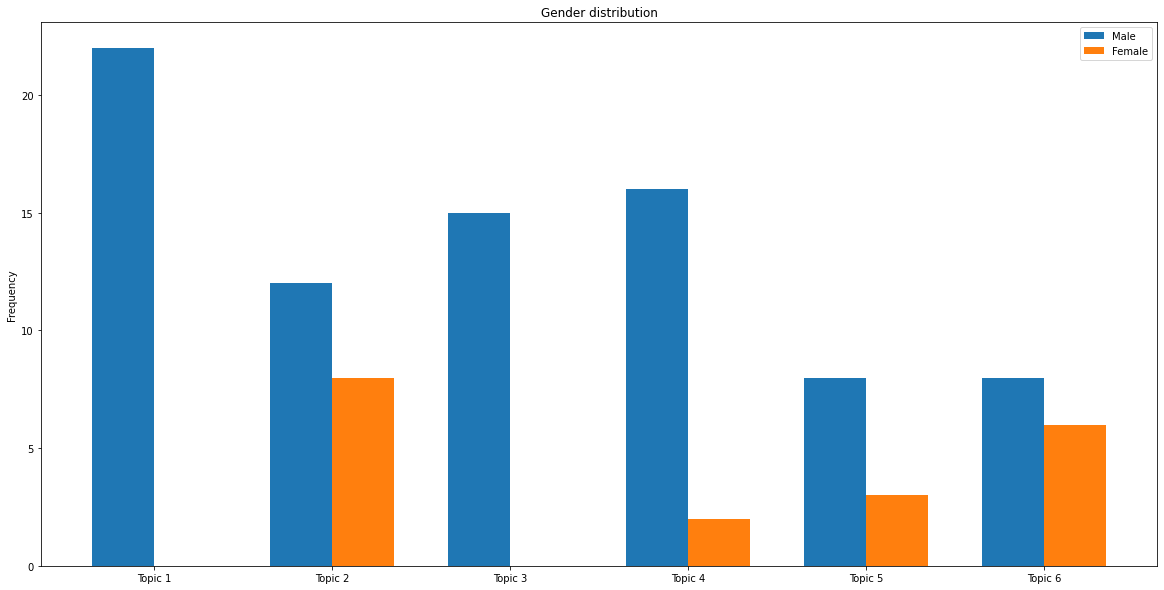

In [41]:
topics=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6']
males=[]
for j in range(n_components):
    males.append(text_data['gender'][np.where(topic_doc==j)[0]].tolist().count('male'))
females=[]
for j in range(n_components):
    females.append(text_data['gender'][np.where(topic_doc==j)[0]].tolist().count('female'))

x = np.arange(len(topics))  
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, males, width, label='Male')
rects2 = ax.bar(x + width/2, females, width, label='Female')

ax.set_ylabel('Frequency')
ax.set_title('Gender distribution')
ax.set_xticks(x)
ax.set_xticklabels(topics)
ax.legend()

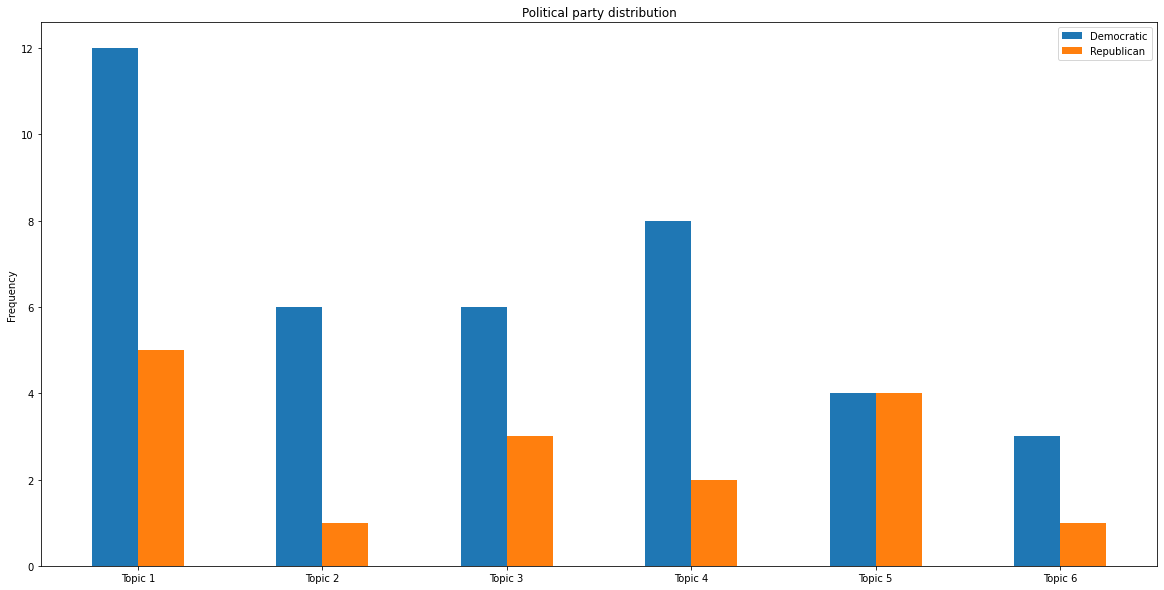

In [42]:
topics=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6']
democratic=[]
for j in range(n_components):
    democratic.append(text_data['party'][np.where(topic_doc==j)[0]].tolist().count('Democratic'))
republican=[]
for j in range(n_components):
    republican.append(text_data['party'][np.where(topic_doc==j)[0]].tolist().count('Republican'))
#null=[]
#for j in range(n_components):
    #null.append(text_data['party'][np.where(topic_doc==j)[0]].tolist().count('Null'))

x = np.arange(len(topics))  
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, democratic, width, label='Democratic')
rects2 = ax.bar(x + width/2, republican, width, label='Republican')
#rects3 = ax.bar(x + width*1.5, null, width, label='Null')

ax.set_ylabel('Frequency')
ax.set_title('Political party distribution')
ax.set_xticks(x)
ax.set_xticklabels(topics)
ax.legend()

### frequency plot of different parties

<AxesSubplot:title={'center':'Frequency of Words Democratic'}>

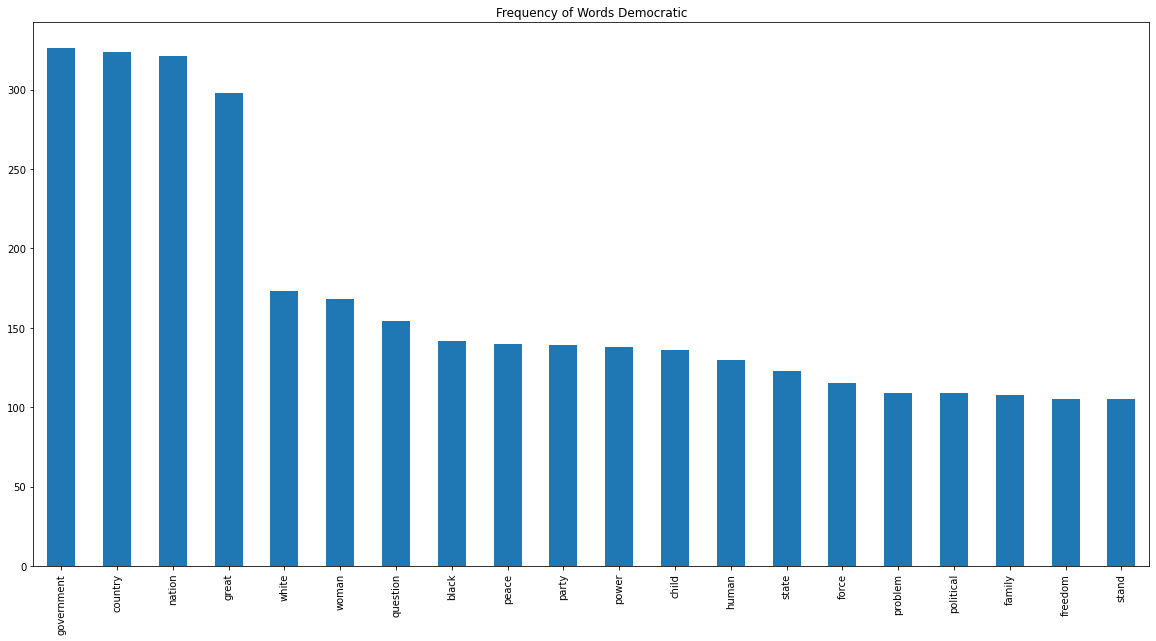

In [43]:
Democratic=text_data.query('party == "Democratic"')
freq= pd.Series((' '.join(Democratic['clean']).split())).value_counts().sort_values(ascending = False)
freq1=freq[0:20]
freq1.plot(kind='bar',title="Frequency of Words Democratic")

<AxesSubplot:title={'center':'Frequency of Words Republican'}>

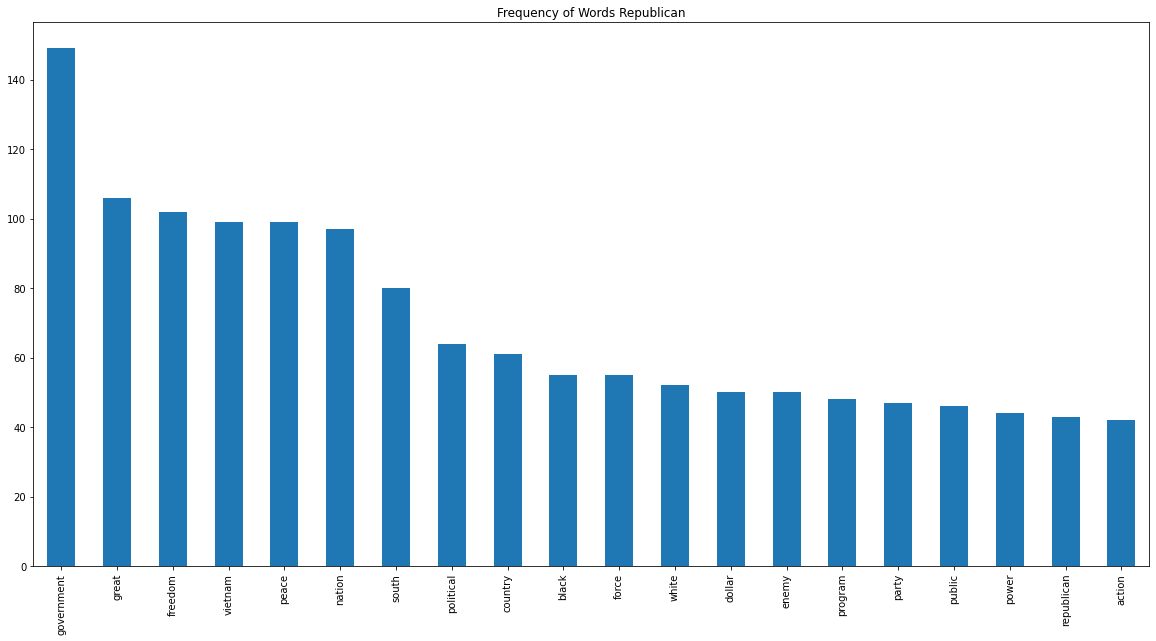

In [44]:
Republican=text_data.query('party == "Republican"')
freq= pd.Series((' '.join(Republican['clean']).split())).value_counts().sort_values(ascending = False)
freq1=freq[0:20]
freq1.plot(kind='bar',title="Frequency of Words Republican")

From the frequency plot, we found that there are differences on words uses between the two parties. The democratic pay more attention on the woman and family topic, while the republicans  focus on the economic growth, war and construction. The democratic emphasize on the government and the country while the republicans think that the individual freedom is more important, that's how they different in the values.